# Intercomparison of AVHRR fire data vs other fire records

This script generates Extended Data Figures 1 & 2.

Intercomparison of AVHRR annual fire count data vs.:

* USA NIFC fire terrestrial records
* Canada NFDB terrestrial records 
* European terrestrial EFFIS
* MODIS Active fires (nighttime, and daytime)

In [1]:
import sys
import os

import csv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset
import datetime as dt
from scipy import stats
from pathlib import Path

#custom
sys.path.append('./../../lib')
import paths as paths
import utils as utils

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

define a plotting function

In [2]:
def panel_scatter_plot(d, xvar, yvar, panelvar, xlab, ylab, nrow, ncol, dim = None, 
                       labelcol=None):
    """ 
    
    simple multipanel plotter 
    
    
    
    usage e.g.:
    
    panel_scatter_plot(d=terrestrial_sub2, 
                   xvar='val_count_1st', yvar='count_1st', panelvar='NAME_0', 
                   xlab='Terrestrial database annual fire count (1st differences)', 
                   ylab='AVHRR annual fire count (1st differences)', 
                   nrow=4, ncol=2)
    """
    
    if dim:
        pass
    else:
        dim=(8,12)
        
    fig, axes = plt.subplots(figsize=dim, nrows=nrow, ncols=ncol, 
                             squeeze=False, sharex=False, sharey=False, 
                             gridspec_kw=dict(hspace=0.4, wspace=0.5))
    axes = axes.flatten()
    
    statstable = pd.DataFrame({'region': [],                               
                               'tau':[],'p':[],'intercept': [],
                               'slope':[],'lower':[],'upper':[],
                              })

    #mpl.rcParams.update({'font.size': 10})
    for i, name in enumerate(np.unique(d[panelvar])):
        ax = axes[i]
        df = d[d[panelvar] == name]
        y = df[yvar].values
        x = df[xvar].values

        # calculate stats and collate
        #lr_m, lr_c, lr_r, lr_p, lr_se = stats.linregress(x=x, y=y)
        tau, tau_p = stats.kendalltau(x=x, y=y)
        ts_m, ts_c, ts_lower, ts_upper = stats.theilslopes(x=x, y=y, alpha=0.95)        
        #print(name,tau_p)
        
        statstable.loc[len(statstable)] = [name,
                         round(tau,5), round(tau_p,5), round(ts_c,5), 
                         round(ts_m,5), round(ts_lower,5), round(ts_upper,5)]
        
        if tau_p < 0.1:
            ax.plot(x, y, marker='o', ms=5, linestyle='none', color='#ec7014', alpha=0.7)
            ax.plot(x, x * ts_m + ts_c,'#cc4c02', linewidth=2, linestyle='-')
            
            # with eq
            #lab = ('{0}\n'
            #       r'$\tau$={1:.2f}, p={2:.3f}'
            #       '\ny={3:.3f}x{4:+.2f}\nn={5}').format(name, tau, tau_p, ts_m, ts_c, df.shape[0])            
            
            # no eq
            if tau_p < 0.001:
                lab = (r'$\tau$={0:.2f}, p<0.001'
                       '\nn={1}').format(tau, df.shape[0]) 
            else:
                lab = (r'$\tau$={0:.2f}, p={1:.3f}'
                       '\nn={2}').format(tau, tau_p, df.shape[0])            

            ax.text(0.02, 0.95, lab, 
                    horizontalalignment='left',
                    verticalalignment='top', 
                    transform=ax.transAxes,
                    fontsize=8)
        else:
            ax.plot(x, y, marker='o', ms=5, linestyle='none', color='#969696', alpha=0.7)
            lab = 'p={0:.3f} \nn={1}'.format(tau_p, df.shape[0])
            ax.text(0.02, 0.95, lab, 
                    horizontalalignment='left',
                    verticalalignment='top', 
                    transform=ax.transAxes,
                    fontsize=8)          
        # make plots square
        ratio = 1.0
        xleft, xright = ax.get_xlim()
        ybottom, ytop = ax.get_ylim()
        ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
        
        # tick label size
        ax.tick_params(axis='both', which='both', labelsize=8)
        if labelcol:
            ax.set_title(df[labelcol].values[0], fontsize=9)
        else:
            ax.set_title(name, fontsize=9)

    # broad axis labels on dummy ax
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel(xlab,fontsize=10, labelpad=15)
    plt.ylabel(ylab,fontsize=10, labelpad=15)   
    
    return fig, axes, statstable

define some helper functions

In [3]:
def grouped_first_diff(df, sortCol, diffCol, outCol, sortAsc=True):
    """ pandas .apply() function
    sort on sortCol, then calc first diff using diffCol"""
    df = df.sort_values(sortCol, ascending=sortAsc)
    df[outCol] = df[diffCol] - df[diffCol].shift(1)
    return df

def grouped_norm_trends(df, sortCol, normCol, outCol, sortAsc=True):
    df = df.sort_values(sortCol, ascending=sortAsc)
    val1 = df[normCol].values[0]
    df[outCol] = df[normCol] / val1
    return df

def grouped_add_rank(d):
    """create a single column index based on existing sorted order within group"""
    d.reset_index(inplace=True, drop=True)
    d.reset_index(inplace=True, drop=False)
    d.rename(columns={'index': 'rank'}, inplace=True)
    return(d)

setup file paths

In [4]:
dir_base = Path(paths.dir_main)

dir_out_figures = dir_base / "outputs"

# paths to AVHRR data aggregated annually by both GFED regions and countries
fn_av_gfed = dir_base / "GFED_annual_counts_calendaryr.csv"
fn_av_countries = dir_base / "NE_50m_ADM0_country_annual_fire_count_totals.csv"

#paths to terrestrial data files
fn_usa = dir_base / "aux_data/US_NIFC_data/US_FIFC_data3.csv"
fn_effis_ba = dir_base / "aux_data/effis/burnt_area_SSA8Odn.csv"
fn_effis_count = dir_base / "aux_data/effis/Number_of_fires_XR3J6B6.csv"
fn_canada = dir_base / "aux_data/canada_nfdb/NFDB_point_20171106_large_fires.csv"

# paths to MODIS Aqua files
fn_modis_aqua_am = dir_base / "aux_data/modis/MODIS_aqua_hotspots_masked_am.csv.gz"
fn_modis_aqua_pm = dir_base / "aux_data/modis/MODIS_aqua_hotspots_masked_pm.csv.gz"

# conversion factor mm -> inches. used for figure sizing.
mm = 1/25.4

# 1) preprocess inputs for terrestrial intercomparison
* how does AVHRR data compare to data from terrestrial country level fire records?

### AVHRR country level data

In [5]:
# load AVHRR annual count data from country level (Admin level 0) file
av_countries = pd.read_csv(str(fn_av_countries))
av_countries.rename(columns = {'ADM0_A3':'GID_0', 'ADMIN':'NAME_0'}, inplace = True)

# extract avhrr data for USA and Canada
av_usa = av_countries[av_countries['GID_0']=='USA']
av_can = av_countries[av_countries['GID_0']=='CAN']

### Preprocess data for USA
* Load the NIFC dataset and convert Acres -> Ha
* Merge with AVHRR data for USA
* Calculate first differences (https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775)

In [6]:
# load and filter
usa = pd.read_csv(str(fn_usa))
usa = usa[['Year', 'Fires', 'Acres']]

# convert to ha
usa['Acres'] = np.round(usa['Acres'] * 0.404686, 0).astype(int)

# format columns
usa.rename(columns = {'Year':'year', 'Acres':'val_ba', 'Fires':'val_count'}, inplace = True)

# combine NIFC data with avhrr data
usa = usa.merge(av_usa, left_on='year', right_on='year')[['GID_0', 'NAME_0', 'year','val_count', 'val_ba', 'count']]
usa.sort_values(['year'], inplace=True)

# calc first differences by subtracting the prior observation i.e. y'(t) = y(t) - y(t-1)
usa['val_ba_1st'] = usa['val_ba'] - usa['val_ba'].shift(1)
usa['val_count_1st'] = usa['val_count'] - usa['val_count'].shift(1)
usa['count_1st'] = usa['count'] - usa['count'].shift(1)
usa.head()

,GID_0,NAME_0,year,val_count,val_ba,count,val_ba_1st,val_count_1st,count_1st
22,USA,United States of America,1986,85907,1100407,602.0,NaN,NaN,NaN
21,USA,United States of America,1989,48949,739487,709.0,-360920.0,-36958.0,107.0
20,USA,United States of America,1990,66481,1870305,429.0,1130818.0,17532.0,-280.0
19,USA,United States of America,1991,75754,1195272,416.0,-675033.0,9273.0,-13.0
18,USA,United States of America,1996,96363,2454824,769.0,1259552.0,20609.0,353.0


### load Canada NFDB 'large fires'
* apply some filters
* aggregate annually to count and calculate total BA
* merge with AVHRR for Canada
* calculate first differences as above

In [7]:
can_raw = pd.read_csv(str(fn_canada))

# filter
can_raw = can_raw[can_raw.LATITUDE > 40]
can_raw = can_raw[can_raw.LATITUDE <= 60]
can_raw = can_raw[can_raw.YEAR_ > 1985]

# generate annual count and BA
can = can_raw[['YEAR_', 'SIZE_HA']]\
    .groupby(['YEAR_'])\
    .agg(['count', 'sum'])\
    .reset_index()\
    .sort_values('YEAR_', ascending=True).droplevel(0, axis=1)
can.rename(columns = {'':'year', 'count':'val_count', 'sum':'val_ba'}, inplace = True)

# combine with AVHRR
can = can.merge(av_can, how='inner', on='year')

# calc first differences by subtracting the prior obs
can['val_ba_1st'] = can['val_ba'] - can['val_ba'].shift(1)
can['val_count_1st'] = can['val_count'] - can['val_count'].shift(1)
can['count_1st'] = can['count'] - can['count'].shift(1)
can.head()

,year,val_count,val_ba,GID_0,NAME_0,sat,sat_yr,count,val_ba_1st,val_count_1st,count_1st
0,1986,129,668145.30,CAN,Canada,NF,NF1986,223.0,NaN,NaN,NaN
1,1989,596,6731375.24,CAN,Canada,NH,NH1989,2593.0,6063229.94,467.0,2370.0
2,1990,221,619109.10,CAN,Canada,NH,NH1990,346.0,-6112266.14,-375.0,-2247.0
3,1991,248,1236604.24,CAN,Canada,NH,NH1991,621.0,617495.14,27.0,275.0
4,1996,369,1443890.10,CAN,Canada,NJ,NJ1996,424.0,207285.86,121.0,-197.0


### European countries from EFFIS 
* load the BA and number (count) of fires datasets from EFFIS
* do some preprocessing
* merge with AVHRR
* Calculate first differences 

In [8]:
# load
effis_ba = pd.read_csv(str(fn_effis_ba))
effis_count = pd.read_csv(str(fn_effis_count))

# rename cols for inconsistent countries
effis_ba.rename(columns = {'Czech Rep.':'Czech Republic', 'FYROM':'Macedonia'}, inplace = True)
effis_count.rename(columns = {'Czech Rep.':'Czech Republic', 'FYROM':'Macedonia'}, inplace = True)

#convert data from wide -> long format
effis_ba_long = pd.melt(effis_ba, id_vars=['year'])
effis_ba_long.rename(columns = {'variable':'NAME_0', 'value':'val_ba'}, inplace = True)
effis_ba_long.head()

effis_count_long = pd.melt(effis_count, id_vars=['year'])
effis_count_long.rename(columns = {'variable':'NAME_0', 'value':'val_count'}, inplace = True)
effis_count_long.head()

# merge the EFFIS data with AVHRR data, retaining only matching countries.
euro = av_countries.merge(right=effis_ba_long, how='inner', on=['NAME_0', 'year'])
euro = euro.merge(right=effis_count_long, how='inner', on=['NAME_0', 'year'])
#euro = euro.sort_values(['count'])

# get rid of NAs
euro.dropna(inplace=True)

# apply function that calculates first differences on a pandas 'groupby' based on country
euro = euro.groupby(['NAME_0','GID_0'])\
    .apply(grouped_first_diff, sortCol='year', diffCol='count', outCol='count_1st').reset_index(drop=True)
euro = euro.groupby(['NAME_0','GID_0'])\
    .apply(grouped_first_diff, sortCol='year', diffCol='val_ba', outCol='val_ba_1st').reset_index(drop=True)
euro = euro.groupby(['NAME_0','GID_0'])\
    .apply(grouped_first_diff, sortCol='year', diffCol='val_count', outCol='val_count_1st').reset_index(drop=True)

euro.head(5)

C:\Users\mdejong\AppData\Local\Temp\ipykernel_96044\4079593496.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  euro = euro.groupby(['NAME_0','GID_0'])\
C:\Users\mdejong\AppData\Local\Temp\ipykernel_96044\4079593496.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  euro = euro.groupby(['NAME_0','GID_0'])\
C:\Users\mdejong\AppData\Local\Temp\ipykernel_96044\4079593496.py:31: DeprecationWarning: DataFr

,GID_0,NAME_0,sat,sat_yr,year,count,val_ba,val_count,count_1st,val_ba_1st,val_count_1st
0,DZA,Algeria,NN,NN2011,2011,10.0,13593.0,2487.0,NaN,NaN,NaN
1,DZA,Algeria,NN,NN2012,2012,87.0,99061.0,5110.0,77.0,85468.0,2623.0
2,DZA,Algeria,NP,NP2013,2013,7.0,13396.0,2443.0,-80.0,-85665.0,-2667.0
3,DZA,Algeria,NP,NP2014,2014,18.0,43125.0,4629.0,11.0,29729.0,2186.0
4,DZA,Algeria,NP,NP2015,2015,5.0,13010.0,2383.0,-13.0,-30115.0,-2246.0


In [9]:
# combine
terrestrial = pd.concat([usa[['GID_0', 'NAME_0', 'year', 'count', 'val_ba', 'val_count', 'count_1st', 'val_ba_1st', 'val_count_1st']], 
                        can[['GID_0', 'NAME_0', 'year', 'count', 'val_ba', 'val_count', 'count_1st', 'val_ba_1st', 'val_count_1st']], 
                        euro[['GID_0', 'NAME_0', 'year', 'count', 'val_ba', 'val_count', 'count_1st', 'val_ba_1st', 'val_count_1st']]
                        ])

# remove rows with NAs
terrestrial = terrestrial.dropna()
terrestrial.head(5)

,GID_0,NAME_0,year,count,val_ba,val_count,count_1st,val_ba_1st,val_count_1st
21,USA,United States of America,1989,709.0,739487.0,48949.0,107.0,-360920.0,-36958.0
20,USA,United States of America,1990,429.0,1870305.0,66481.0,-280.0,1130818.0,17532.0
19,USA,United States of America,1991,416.0,1195272.0,75754.0,-13.0,-675033.0,9273.0
18,USA,United States of America,1996,769.0,2454824.0,96363.0,353.0,1259552.0,20609.0
17,USA,United States of America,1997,408.0,1156171.0,66196.0,-361.0,-1298653.0,-30167.0


### subset and plot the AVHRR vs terrestrial data
* supplemental figure 1a
* keep only the regions with records for all years in the AVHRR dataset AND have mean BA > 50,000 Ha per year.

In [10]:
# subset
terrestrial = terrestrial.loc[terrestrial.NAME_0.isin(['Canada','United States of America',
                                                       'Spain','Portugal','Italy'])]
# scale data for legible axes
terrestrial.val_ba = terrestrial.val_ba / 1000
terrestrial.val_ba_1st = terrestrial.val_ba_1st / 1000

C:\Users\mdejong\AppData\Local\Temp\ipykernel_96044\3298660846.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


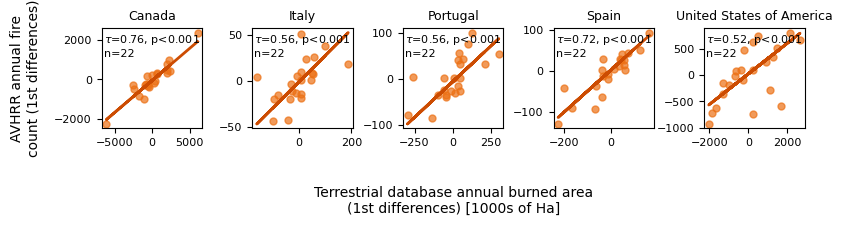

In [11]:
fig, axes, summary = panel_scatter_plot(d=terrestrial, 
                                        xvar='val_ba_1st', 
                                        yvar='count_1st', panelvar='NAME_0', 
                                        xlab='Terrestrial database annual burned area\n(1st differences) [1000s of Ha]', 
                                        ylab='AVHRR annual fire\ncount (1st differences)', 
                                        nrow=1, ncol=5, dim=(210*mm,60*mm)) 

fig.tight_layout()
fig.savefig(str(dir_out_figures / 's01a_terrestrial_intercomparison.png'), dpi=800)
fig.savefig(str(dir_out_figures / 's01a_terrestrial_intercomparison.pdf'))
summary.to_csv(str(dir_out_figures / 's01a_terrestrial_intercomparison.csv'), index=False)

# 2) Intercomparison with MODIS AQUA AM (Nighttime)

modis counts generated using 01c_mask_modis_v01.ipynb

* supplemental figure 1b
* Aqua AM overpass is the most similar observation time to AVHRR, so the most direct comparison for evaluation

In [12]:
#load AVHRR annual count data by GFED regions
av_gfed = pd.read_csv(str(fn_av_gfed))
print(av_gfed.shape)

av_gfed.rename(columns = {'gfed':'region', 'gfed_name':'region_name'}, inplace = True)
av_gfed = av_gfed.loc[av_gfed.region_name != 'Mask']\
          .sort_values(['region','year'], ascending=True)

#fix Typo
av_gfed.loc[av_gfed.region_name=='SEAS','region_name'] = 'SOAS'

av_gfed.head()

(368, 6)


,sat_yr,sat,year,region,region_name,count
1,NF1986,NF,1986,1,BONA,228
16,NH1989,NH,1989,1,BONA,2584
31,NH1990,NH,1990,1,BONA,338
46,NH1991,NH,1991,1,BONA,609
61,NJ1996,NJ,1996,1,BONA,428


load the MODIS Aqua AM data

In [13]:
modis_raw = pd.read_csv(str(fn_modis_aqua_am))
modis_raw.rename(columns = {'gfed':'region', 'gfed_name':'region_name'}, inplace = True)
modis_raw.head()

,lat,lon180,lon360,dt_utc,dt_lst,hours_lst,date_lst,month,year,doy,region,region_name
0,8.1449,20.1377,20.1377,2003-01-01 00:26:00,2003-01-01 01:43:52.291951,1.0,2003-01-01,1,2003,1,8,NHAF
1,8.1174,20.0504,20.0504,2003-01-19 00:14:00,2003-01-19 01:24:22.879528,1.0,2003-01-19,1,2003,19,8,NHAF
2,8.1161,20.0594,20.0594,2003-01-19 00:14:00,2003-01-19 01:24:25.039528,1.0,2003-01-19,1,2003,19,8,NHAF
3,7.3885,26.2658,26.2658,2003-01-01 00:26:00,2003-01-01 02:08:23.035951,2.0,2003-01-01,1,2003,1,8,NHAF
4,7.3841,26.2686,26.2686,2003-01-01 00:26:00,2003-01-01 02:08:23.707951,2.0,2003-01-01,1,2003,1,8,NHAF


In [55]:
# aggregate to years
modis2 = modis_raw[['region', 'region_name', 'year', 'doy']]\
    .groupby(['region', 'region_name', 'year'])\
    .agg(['count'])\
    .reset_index()\
    .sort_values('year', ascending=True).droplevel(0, axis=1)
# trim
modis2.columns = ['region', 'region_name', 'year', 'val_count']

### Merge MODIS and AVHRR data and do first differences

In [56]:
# combine regional data
modis2 = modis2.merge(av_gfed, how='inner', on=['region','region_name', 'year'])

## calculate global totals and 
modis_global = modis2[['year','val_count','count']]\
    .groupby(['year'])[['val_count','count']].sum().reset_index()\
    .sort_values('year', ascending=True)
modis_global['region'] = 99
modis_global['region_name'] = 'global'
modis_global['sat_yr'] = 'dummy'
modis_global['sat'] = 'dummy'

# add global to the main df
modis2 = pd.concat([modis2, modis_global])

# calculate first differences for both AVHRR and MODIS
modis2 = modis2.groupby(['region','region_name'])\
    .apply(grouped_first_diff, sortCol='year', diffCol='count', outCol='count_1st').reset_index(drop=True)
modis2 = modis2.groupby(['region','region_name'])\
    .apply(grouped_first_diff, sortCol='year', diffCol='val_count', outCol='val_count_1st').reset_index(drop=True)

C:\Users\mdejong\AppData\Local\Temp\ipykernel_96044\1550082745.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  modis2 = modis2.groupby(['region','region_name'])\
C:\Users\mdejong\AppData\Local\Temp\ipykernel_96044\1550082745.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  modis2 = modis2.groupby(['region','region_name'])\


### apply some formatting and plot

In [57]:
modis3 = modis2.dropna().copy()

modis3['gfed_full_name'] = ''
modis3.loc[modis3.region_name=='BONA', 'gfed_full_name'] = 'Boreal North America (BONA)'
modis3.loc[modis3.region_name=='TENA', 'gfed_full_name'] = 'Temperate North America (TENA)'
modis3.loc[modis3.region_name=='CEAM', 'gfed_full_name'] = 'Central America (CEAM)'
modis3.loc[modis3.region_name=='NHSA', 'gfed_full_name'] = 'Northern Hemisphere \nSouth America (NHSA)'
modis3.loc[modis3.region_name=='SHSA', 'gfed_full_name'] = 'Southern Hemisphere \nSouth America (SHSA)'
modis3.loc[modis3.region_name=='EURO', 'gfed_full_name'] = 'Europe (EURO)'
modis3.loc[modis3.region_name=='MIDE', 'gfed_full_name'] = 'Middle East (MIDE)'
modis3.loc[modis3.region_name=='NHAF', 'gfed_full_name'] = 'Northern Hemisphere \nAfrica (NHAF)'
modis3.loc[modis3.region_name=='SHAF', 'gfed_full_name'] = 'Southern Hemisphere \nAfrica (SHAF)'
modis3.loc[modis3.region_name=='BOAS', 'gfed_full_name'] = 'Boreal Asia (BOAS)'
modis3.loc[modis3.region_name=='CEAS', 'gfed_full_name'] = 'Central Asia (CEAS)'
modis3.loc[modis3.region_name=='SOAS', 'gfed_full_name'] = 'Southern Asia (SOAS)'
modis3.loc[modis3.region_name=='EQAS', 'gfed_full_name'] = 'Equatorial Asia (EQAS)'
modis3.loc[modis3.region_name=='AUST', 'gfed_full_name'] = 'Australasia (AUST)'
modis3.loc[modis3.region_name=='global', 'gfed_full_name'] = 'Global'

C:\Users\mdejong\AppData\Local\Temp\ipykernel_96044\1401192390.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


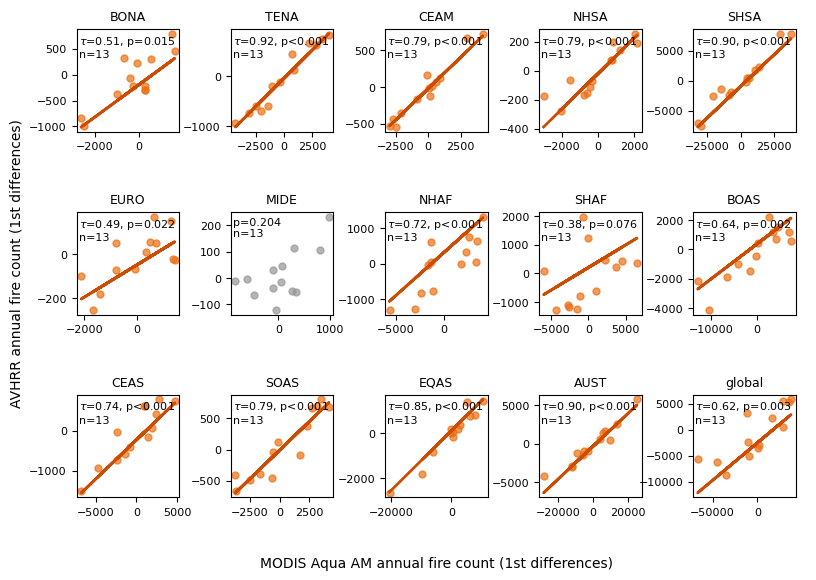

In [17]:
fig, axes, summary = panel_scatter_plot(d=modis3, 
                                        xvar='val_count_1st', 
                                        yvar='count_1st', panelvar='region', 
                                        xlab='MODIS Aqua AM annual fire count (1st differences)', 
                                        ylab='AVHRR annual fire count (1st differences)', 
                                        nrow=3, ncol=5, dim=(210*mm,150*mm),labelcol='region_name') #nrow=3, ncol=5, dim=(12,8)

fig.tight_layout()

fig.savefig(str(dir_out_figures /'s01b_modis_am_intercomparison.png'), dpi=800)
fig.savefig(str(dir_out_figures / 's01b_modis_am_intercomparison.pdf'))
summary.to_csv(str(dir_out_figures / 's01b_modis_am_intercomparison.csv'), index=False)

# COMPARE TO MODIS DAYTIME (AQUA PM)
* Does the AVHRR nighttime data broadly reflect observed MODIS **daytime** patterns over the same time period? (supplemental figure 2)

In [20]:
#load MODIS PM
aquapm_raw = pd.read_csv(str(fn_modis_aqua_pm))
aquapm_raw.rename(columns = {'gfed':'region', 'gfed_name':'region_name'}, inplace = True)
aquapm_raw.head()

,lat,lon180,lon360,dt_utc,dt_lst,hours_lst,date_lst,month,year,doy,region,region_name
0,-25.9918,153.0614,153.0614,2003-01-01 02:50:00,2003-01-01 12:59:31.727067,12.0,2003-01-01,1,2003,1,14,AUST
1,-25.9913,153.0655,153.0655,2003-01-01 02:50:00,2003-01-01 12:59:32.711067,12.0,2003-01-01,1,2003,1,14,AUST
2,-25.9942,153.0196,153.0196,2003-01-01 02:50:00,2003-01-01 12:59:21.695067,12.0,2003-01-01,1,2003,1,14,AUST
3,-25.9949,153.0157,153.0157,2003-01-01 02:50:00,2003-01-01 12:59:20.759067,12.0,2003-01-01,1,2003,1,14,AUST
4,-25.9131,153.0672,153.0672,2003-04-20 03:57:00,2003-04-20 14:10:10.485095,14.0,2003-04-20,4,2003,110,14,AUST


In [ ]:
# aggregate to years
df_final_ba_totals = aquapm_raw[['region', 'region_name', 'year', 'doy']]\
    .groupby(['region', 'region_name', 'year'])\
    .agg(['count'])\
    .reset_index()\
    .sort_values('year', ascending=True).droplevel(0, axis=1)

df_final_ba_totals.columns = ['region', 'region_name', 'year', 'val_count']

# combine with annual AVHRR
df_final_ba_totals = df_final_ba_totals.merge(av_gfed, how='inner', on=['region','region_name', 'year'])

## calculate global totals and add to main df
aqua_global = aquapm_year[['year','val_count','count']]\
    .groupby(['year'])[['val_count','count']].sum().reset_index()\
    .sort_values('year', ascending=True)
aqua_global['region'] = 99
aqua_global['region_name'] = 'global'
aqua_global['sat_yr'] = 'dummy'
aqua_global['sat'] = 'dummy'

aquapm_year = pd.concat([df_final_ba_totals, aqua_global])

# calculate first differences
df_final_ba_totals = df_final_ba_totals.groupby(['region','region_name'])\
    .apply(grouped_first_diff, sortCol='year', diffCol='count', outCol='count_1st').reset_index(drop=True)
df_final_ba_totals = df_final_ba_totals.groupby(['region','region_name'])\
    .apply(grouped_first_diff, sortCol='year', diffCol='val_count', outCol='val_count_1st').reset_index(drop=True)

aquapm_year2 = aquapm_year.copy().dropna()

C:\Users\mdejong\AppData\Local\Temp\ipykernel_96044\933313015.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aquapm_year = aquapm_year.groupby(['region','region_name'])\
C:\Users\mdejong\AppData\Local\Temp\ipykernel_96044\933313015.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aquapm_year = aquapm_year.groupby(['region','region_name'])\


### apply some formatting and plot

C:\Users\mdejong\AppData\Local\Temp\ipykernel_96044\1440102163.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


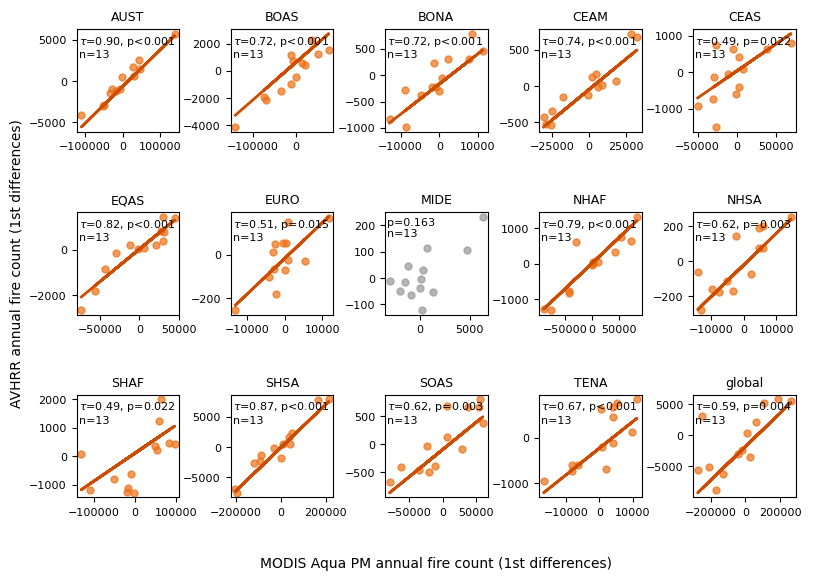

In [22]:
#first diff plot
fig, axes, summary = panel_scatter_plot(d=aquapm_year2, 
                                        xvar='val_count_1st', 
                                        yvar='count_1st', panelvar='region_name', 
                                        xlab='MODIS Aqua PM annual fire count (1st differences)', 
                                        ylab='AVHRR annual fire count (1st differences)', 
                                        nrow=3, ncol=5, dim=(210*mm,150*mm), labelcol='region_name')
fig.tight_layout()
fig.savefig(str(dir_out_figures / 's02_modis_pm_intercomparison.png'), dpi=800)
#fig.savefig(str(dir_out_figures / 's02_modis_pm_intercomparison.pdf'))
summary.to_csv(str(dir_out_figures / 's02_modis_pm_intercomparison.csv'), index=False)

### Timeseries

In [151]:
def ts_plotter(df, xstr, y1str, y2str, series1_str, series2_str, region_dict, ylab, xlab, av_color_list, fw_color_list, 
                   nrow, ncol, dim = None, ax2rm = None, xlabpad=0, sharex=False):
    """ 
    func for plotting AVHRR vs. MODIS timeseries
    
    returns:
    fig: figure object 
    axes: axes objects
    stats: df, summary stats 
    """
    
    eq_list = ['$\leq$', ' > ']
    
    if dim:
        pass
    else:
        dim=(12,8)      
    
    fig, axes = plt.subplots(figsize=dim, nrows=nrow, ncols=ncol,
                           squeeze=False, sharex=sharex,
                           gridspec_kw=dict(hspace=0.35, wspace=0.2))
    axes=axes.flatten()
    
    if ax2rm:   # delete excess axes
        for i in np.arange(ax2rm, 0):
            fig.delaxes(axes[i])
            
    statstable = pd.DataFrame({'region': [],'metric':[],
                           'year_start':[],'year_end' : [], 
                           'tau':[],'p':[],'intercept': [],
                           'slope':[],'lower':[],'upper':[],
                          })
    for i, (key, values) in enumerate(region_dict.items()):
        print(i, key, values)
        sub = df.loc[df.region_name==key].copy()    
        #d_av = d_av.dropna()   
        
        x = sub[xstr].values    
        y1 = sub[y1str].values
        y2 = sub[y2str].values
    
        ax1 = axes[i]

        ### points & markers
        #AVHRR (oranges)
        ax1.plot(x, y1, marker='', ms=4, linestyle='-', color=av_color_list[0], label=key, alpha=1, zorder=1) 
        ax1.plot(x, y1, marker='o', ms=4, linestyle='none', color=av_color_list[1], label=key, alpha=1, zorder=2) #3690c0
        #Other (greys)
        ax1.plot(x, y2, marker='', ms=4, linestyle='-', color=fw_color_list[0], label=key, alpha=1, zorder=2)
        ax1.plot(x, y2, marker='s', ms=4, linestyle='none', color=fw_color_list[1], label=key, alpha=1, zorder=2) #fe9929        
        
        # first calc & store the 1986-2016 AVHRR stats      
        tau2, p2, slope2, intercept2, lower2, upper2 = utils.kendall_theilsen(x, y1)
        #tau_n2, p_n2, slope_n2, intercept_n2, lower_n2, upper_n2 = utils.kendall_theilsen(x, y1)   
        statstable.loc[len(statstable)] = [key, 'avhrr', x[0], x[-1], 
                       round(tau2,6), round(p2,6), round(intercept2,6), 
                       round(slope2,6), round(lower2,6), round(upper2,6)]
        
        # first calc & store the 1986-2016 other stats 
        tau1, p1, slope1, intercept1, lower1, upper1 = utils.kendall_theilsen(x, y2)        
        #tau_n1, p_n1, slope_n1, intercept_n1, lower_n1, upper_n1 = utils.kendall_theilsen(x, y2)
        statstable.loc[len(statstable)] = [key, 'other dataset', x[0], x[-1], 
                         round(tau1,6), round(p1,6), round(intercept1,6), 
                         round(slope1,6), round(lower1,6), round(upper1,6)]    
    

        #PLOT TRENDS ###
        # AVHRR ============
        if values[0]: #i.e. have a change point
            # now do subdivided analysis        
            a = sub.loc[sub.year <= values[0]]
            b = sub.loc[sub.year >  values[0]]
            for k,dd in enumerate([a,b]):
                x = dd[xstr].values        
                y = dd[y1str].values #/ 1000
                #yn = dd[y].values
                txt_offset = k * 0.1
                # calc stats
                tau, p, slope, intercept, lower, upper = utils.kendall_theilsen(x, y)         
                if p < 0.1:
                    ax1.plot(x, x * slope + intercept, av_color_list[2], linewidth=2, linestyle='-', zorder=1000)
                    if p < 0.001:
                        label=r'{} {}{}: {:+.1f} % yr$^1$, p<0.001'.format(series1_str, eq_list[k], values[0], np.round(slope * 100,1)) 
                    else:
                        label=r'{} {}{}: {:+.1f} % yr$^1$, p={:.3f}'.format(series1_str, eq_list[k], values[0], np.round(slope * 100,1), np.round(p,3)) 
                    plt.text(0.02, 0.9 - txt_offset, label, color=av_color_list[2], fontsize=8, transform = ax1.transAxes)
                else:
                    label=r'{} {}{}: no trend, p={:.3f}'.format(series1_str, eq_list[k], values[0], p) 
                    plt.text(0.02, 0.9 - txt_offset, label, color=av_color_list[2], fontsize=8, transform = ax1.transAxes)        
                # collate stats
                statstable.loc[len(statstable)] = [key, 'avhrr', x[0], x[-1], 
                                 round(tau,6), round(p,6), round(intercept,6), 
                                 round(slope,6), round(lower,6), round(upper,6)]
                #print('avhrr p-value:', d_av.gfed_full_name.values[0], p_n)
        else: #i.e. no change point
            if p2 < 0.1:
                ax1.plot(x, x * slope2 + intercept2, av_color_list[2], linewidth=2, linestyle='-', zorder=1000)
                if p2 < 0.001:
                    label=r'{} {:+.1f} % yr$^1$, p<0.001'.format(series1_str, np.round(slope2 * 100,1)) 
                else:            
                    label=r'{} {:+.1f} % yr$^1$, p={:.3f}'.format(series1_str, np.round(slope2 * 100,1), np.round(p2,3)) 
                plt.text(0.02, 0.9, label, color=av_color_list[2], fontsize=8, transform = ax1.transAxes)
            else:
                label=r'{} no trend, p={:.3f}'.format(series1_str, np.round(p2,3)) 
                plt.text(0.02, 0.9, label, color=av_color_list[2], fontsize=8, transform = ax1.transAxes)        
            #print('avhrr p-value:', d_av.gfed_full_name.values[0], p_n2)
        
        #  OTHER ===========
        if values[1]:
            # now do subdivided analysis
            a = sub.loc[sub.year <= values[1]]
            b = sub.loc[sub.year >  values[1]]
            for k,dd in enumerate([a,b]):
                x = dd[xstr].values        
                y = dd[y2str].values
                
                txt_offset = k * 0.1
                # calc stats
                tau, p, slope, intercept, lower, upper = utils.kendall_theilsen(x, y)        
                #tau_n, p_n, slope_n, intercept_n, lower_n, upper_n = utils.kendall_theilsen(x, y)        

                if values[0]: # if AVHRRR has a change, change loc of meteo label
                    yloc=0.7 - txt_offset
                else:
                    yloc=0.8 - txt_offset

                if p < 0.1:
                    ax1.plot(x, x * slope + intercept, fw_color_list[2], linewidth=2, linestyle='-', zorder=1000)
                    if p < 0.001:
                        label=r'{} {}{}: {:+.1f} % yr$^1$, p<0.001'.format(series2_str, eq_list[k], values[1], np.round(slope * 100,1)) 
                    else:
                        label=r'{} {}{}: {:+.1f} % yr$^1$, p={:.3f}'.format(series2_str, eq_list[k], values[1], np.round(slope * 100,1), np.round(p,3)) 
                    plt.text(0.02, yloc, label, color=fw_color_list[2], fontsize=8, transform = ax1.transAxes)
                else:
                    label=r'{} {}{}: p={:.3f}'.format(series2_str, eq_list[k], values[1], np.round(p,3)) 
                    label=r'{} {}{}: no trend, p={:.3f}'.format(series2_str, eq_list[k], values[1], np.round(p,3))                 
                    plt.text(0.02, yloc, label, color=fw_color_list[2], fontsize=8, transform = ax1.transAxes)        
                # collate stats
                statstable.loc[len(statstable)] = [key, 'other', x[0], x[-1], 
                                 round(tau,6), round(p,6), round(intercept,6), 
                                 round(slope,6), round(lower,6), round(upper,6)]
        else:
            txt_offset = 1 * 0.1
            if values[0]: # if AVHRRR has a change
                yloc=0.7
            else:
                yloc=0.9 - txt_offset        
            if p1 < 0.1:
                ax1.plot(x, x * slope1 + intercept1, fw_color_list[2], linewidth=2, linestyle='-', zorder=1000)
                if p1 < 0.001:
                    label=r'{} {:+.1f} % yr$^1$, p<0.001'.format(series2_str, np.round(slope1 * 100,1)) 
                else:
                    label=r'{} {:+.1f} % yr$^1$, p={:.3f}'.format(series2_str, np.round( slope1 * 100,1), np.round(p1,3)) 
                plt.text(0.02, yloc, label, color=fw_color_list[2], fontsize=8, transform = ax1.transAxes)
            else:
                label=r'{} p={:.3f}'.format(series2_str, np.round(p1,3))
                label=r'{} no trend, p={:.3f}'.format(series2_str, np.round(p1,3))
                plt.text(0.02, yloc, label, color=fw_color_list[2], fontsize=8, transform = ax1.transAxes)        
        #print(d_fw.gfed_full_name.values[0], p_n1)
        
        # tidy up subplot
        ax1.set_title(sub.gfed_full_name.values[0], fontsize=10)   
        # expand upper y limits for text
        ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1] * 1.1)

        # adjust tick label font sizes
        ax1.tick_params(axis='both', which='major', labelsize=8)
        ax1.tick_params(axis='both', which='minor', labelsize=8)
        
    # broad axis labels on dummy ax
    fig.add_subplot(111, frameon=False)
    ax1 = plt.gca()
    #ax2 = ax1.twinx()
    ax1.set_xlabel(xlab, color='k', fontsize=10, labelpad=xlabpad)
    ax1.set_ylabel(ylab, color='k', fontsize=10, labelpad=0)    
    
    plt.box(False)
    ax1.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    return fig, axes, statstable

In [160]:
# colour palettes for plotting
av_color_list = ['#fec44f','#ec7014','#cc4c02'] #oranges  #fe9929
fw_color_list = ['#dcdcdc','#bdbdbd','#969696'] #greys
ba_color_list = ["#4299fd","#2488fa","#0075fc"] #greys
#params for figure set up
mm = 1/25.4

First lets plot the AVHRR against the nightime Aqua MODIS observations

Add some stuff to help plotting

In [ ]:
modis2['gfed_full_name'] = ''
modis2.loc[modis2.region_name=='BONA', 'gfed_full_name'] = 'Boreal North America (BONA)'
modis2.loc[modis2.region_name=='TENA', 'gfed_full_name'] = 'Temperate North America (TENA)'
modis2.loc[modis2.region_name=='CEAM', 'gfed_full_name'] = 'Central America (CEAM)'
modis2.loc[modis2.region_name=='NHSA', 'gfed_full_name'] = 'Northern Hemisphere South America (NHSA)'
modis2.loc[modis2.region_name=='SHSA', 'gfed_full_name'] = 'Southern Hemisphere South America (SHSA)'
modis2.loc[modis2.region_name=='EURO', 'gfed_full_name'] = 'Europe (EURO)'
modis2.loc[modis2.region_name=='MIDE', 'gfed_full_name'] = 'Middle East (MIDE)'
modis2.loc[modis2.region_name=='NHAF', 'gfed_full_name'] = 'Northern Hemisphere Africa (NHAF)'
modis2.loc[modis2.region_name=='SHAF', 'gfed_full_name'] = 'Southern Hemisphere Africa (SHAF)'
modis2.loc[modis2.region_name=='BOAS', 'gfed_full_name'] = 'Boreal Asia (BOAS)'
modis2.loc[modis2.region_name=='CEAS', 'gfed_full_name'] = 'Central Asia (CEAS)'
modis2.loc[modis2.region_name=='SOAS', 'gfed_full_name'] = 'Southern Asia (SOAS)'
modis2.loc[modis2.region_name=='EQAS', 'gfed_full_name'] = 'Equatorial Asia (EQAS)'
modis2.loc[modis2.region_name=='AUST', 'gfed_full_name'] = 'Australasia (AUST)'
modis2.loc[modis2.region_name=='global', 'gfed_full_name'] = 'Global'

print(np.max(modis2.year))
modis2.head()


2016


,region,region_name,year,val_count,sat_yr,sat,count,count_1st,val_count_1st,gfed_full_name,n_count_avhrr,n_count_modis,n_count_avhrr_mean,n_count_modis_mean
0,1,BONA,2003,3438,NL2003,NL,1305,NaN,NaN,Boreal North America (BONA),1.000000,1.000000,2.182535,2.243498
1,1,BONA,2004,961,NL2004,NL,322,-983.0,-2477.0,Boreal North America (BONA),0.246743,0.279523,0.538526,0.627109
2,1,BONA,2005,571,NL2005,NL,263,-59.0,-390.0,Boreal North America (BONA),0.201533,0.166085,0.439852,0.372611
3,1,BONA,2006,1129,NN2006,NN,567,304.0,558.0,Boreal North America (BONA),0.434483,0.328389,0.948274,0.736739
4,1,BONA,2007,864,NN2007,NN,338,-229.0,-265.0,Boreal North America (BONA),0.259004,0.251309,0.565285,0.563811


In [75]:
# turn off all change points, we are now working with a very small part of the avhrr timeseries

region_dict = {'BONA':  [None, None],
               'TENA':  [None, None], 
               'CEAM':  [None, None], 
               'NHSA':  [None, None],  
               'SHSA':  [None, None],
               'EURO':  [None, None],
               'MIDE':  [None, None],
               'NHAF':  [None, None],
               'SHAF':  [None, None],
               'BOAS':  [None, None],
               'CEAS':  [None, None],
               'SOAS':  [None, None], 
               'EQAS':  [None, None],
               'AUST':  [None, None]
              }


test two different ways of normalising the the time series for comparison

In [59]:
# normalise data to first year (2003)

# AVHRR
avhrr2003 = modis2.loc[modis2.year == 2003].rename(columns={'count':'count86a'})
#norm the ensemble stats
modis2 = modis2.merge(avhrr2003[['region','region_name','count86a']],
                      how='left',
                      on=['region','region_name'])
modis2['n_count_avhrr'] = modis2['count'] / modis2['count86a'] 

#MODIS
modis2003 = modis2.loc[modis2.year == 2003].rename(columns={'val_count':'count86m'})
#norm the ensemble stats
modis2 = modis2.merge(modis2003[['region','region_name','count86m']],
                      how='left',
                      on=['region','region_name'])
modis2['n_count_modis'] = modis2['val_count'] / modis2['count86m'] 

# drop unused
modis2 = modis2.drop(['count86a','count86m'], axis=1)
modis2.head()


,region,region_name,year,val_count,sat_yr,sat,count,count_1st,val_count_1st,gfed_full_name,n_count_avhrr,n_count_modis
0,1,BONA,2003,3438,NL2003,NL,1305,NaN,NaN,Boreal North America (BONA),1.000000,1.000000
1,1,BONA,2004,961,NL2004,NL,322,-983.0,-2477.0,Boreal North America (BONA),0.246743,0.279523
2,1,BONA,2005,571,NL2005,NL,263,-59.0,-390.0,Boreal North America (BONA),0.201533,0.166085
3,1,BONA,2006,1129,NN2006,NN,567,304.0,558.0,Boreal North America (BONA),0.434483,0.328389
4,1,BONA,2007,864,NN2007,NN,338,-229.0,-265.0,Boreal North America (BONA),0.259004,0.251309


In [ ]:
# normalise data to mean

# AVHRR
avhrr_mean = modis2.groupby('region')['count'].mean().reset_index().rename(columns={'count':'avhrr_mean'})

#norm the ensemble stats
modis2 = modis2.merge(avhrr_mean[['region','avhrr_mean']],
                      how='left',
                      on=['region'])
modis2['n_count_avhrr_mean'] = modis2['count'] / modis2['avhrr_mean'] 

# #MODIS
modis_mean = modis2.groupby('region')['val_count'].mean().reset_index().rename(columns={'val_count':'modis_mean'})

#norm the ensemble stats
modis2 = modis2.merge(modis_mean[['region','modis_mean']],
                      how='left',
                      on=['region'])
modis2['n_count_modis_mean'] = modis2['val_count'] / modis2['modis_mean'] 

# drop unused
modis2 = modis2.drop(['avhrr_mean','modis_mean'], axis=1)
modis2.head()



0 BONA [None, None]
1 TENA [None, None]
2 CEAM [None, None]
3 NHSA [None, None]
4 SHSA [None, None]
5 EURO [None, None]
6 MIDE [None, None]
7 NHAF [None, None]
8 SHAF [None, None]
9 BOAS [None, None]
10 CEAS [None, None]
11 SOAS [None, None]
12 EQAS [None, None]
13 AUST [None, None]


C:\Users\mdejong\AppData\Local\Temp\ipykernel_96044\4148506873.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


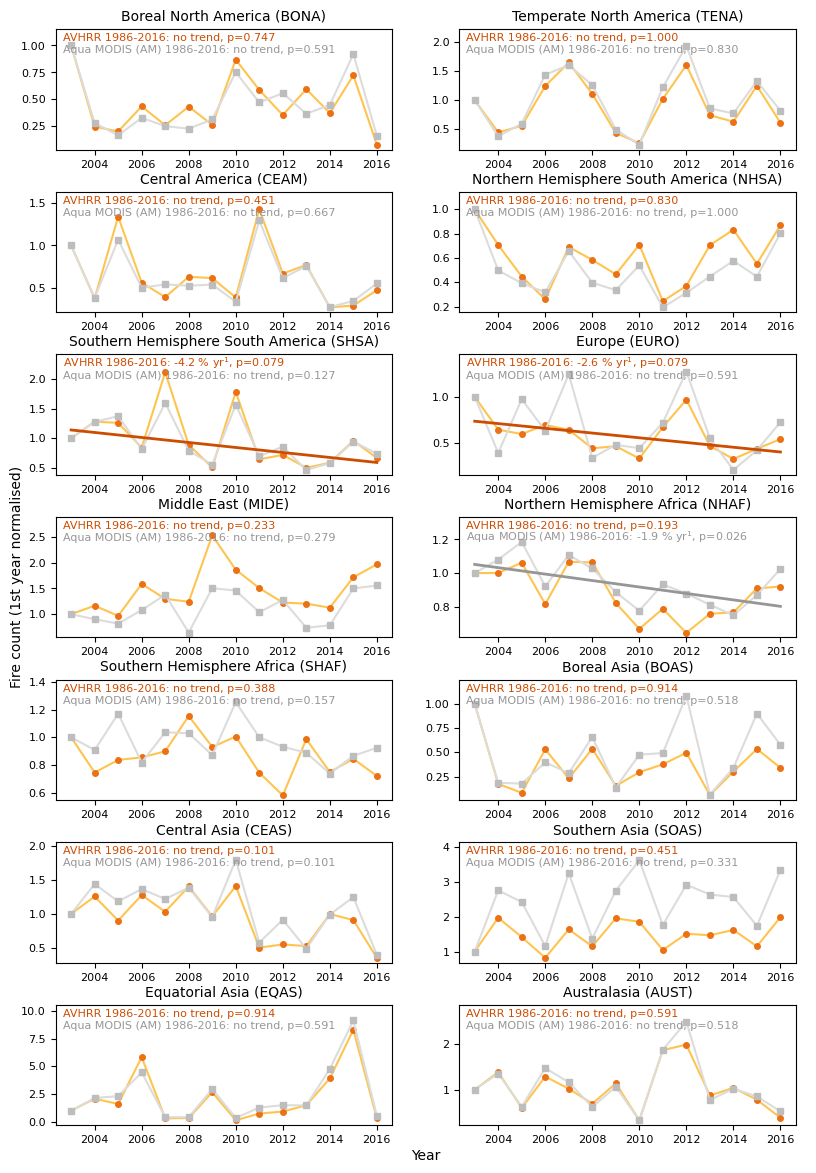

In [ ]:

fig, axes, stats_tbl = ts_plotter(df=modis2, 
                                xstr='year',
                                y1str='n_count_avhrr',
                                y2str='n_count_modis',
                                series1_str = 'AVHRR',
                                series2_str = 'Aqua MODIS (AM)',
                                region_dict=region_dict, 
                                ylab="Fire count (1st year normalised)",
                                xlab="Year", 
                                av_color_list=av_color_list, fw_color_list=fw_color_list, 
                                nrow=7, ncol=2, 
                                dim = (210*mm,297*mm))
fig.tight_layout()


#figs
fig.savefig(str(dir_out_figures / 's11_timeseries_AVHRR_vs_MODIS_AM_1st_year_normalised.png'), dpi=1000)
#fig.savefig(str(dir_out_figures / 's4_timeseries_gfed_vpd_flip.pdf'))

#statstable
#stats_tbl.to_csv(str(dir_out_figures / 's4_timeseries_gfed_vpd_flip.csv'),index=False)
#print(stats_tbl)

0 BONA [None, None]
1 TENA [None, None]
2 CEAM [None, None]
3 NHSA [None, None]
4 SHSA [None, None]
5 EURO [None, None]
6 MIDE [None, None]
7 NHAF [None, None]
8 SHAF [None, None]
9 BOAS [None, None]
10 CEAS [None, None]
11 SOAS [None, None]
12 EQAS [None, None]
13 AUST [None, None]


C:\Users\mdejong\AppData\Local\Temp\ipykernel_96044\2793698843.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


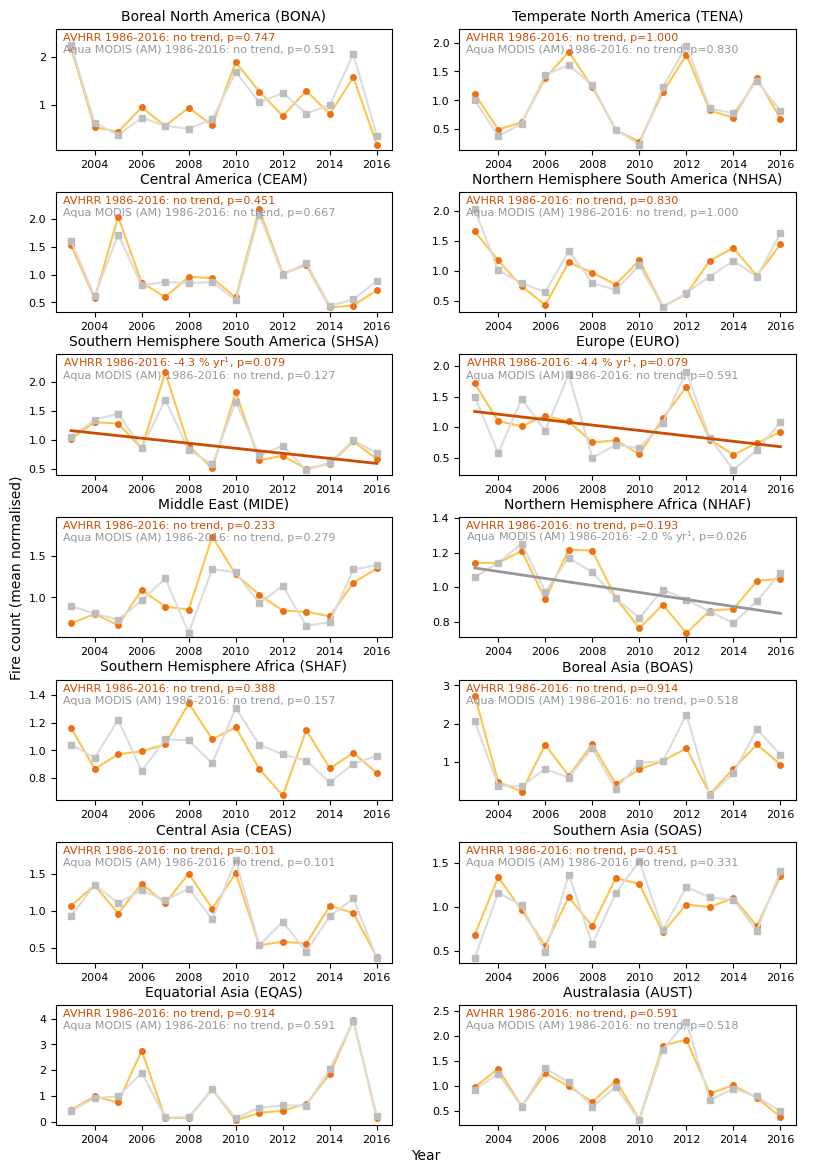

In [ ]:
fig, axes, stats_tbl = ts_plotter(df=modis2, 
                                xstr='year',
                                y1str='n_count_avhrr_mean',
                                y2str='n_count_modis_mean',
                                series1_str = 'AVHRR',
                                series2_str = 'Aqua MODIS (AM)',
                                region_dict=region_dict, 
                                ylab="Fire count (mean normalised)",
                                xlab="Year", 
                                av_color_list=av_color_list, fw_color_list=fw_color_list, 
                                nrow=7, ncol=2, 
                                dim = (210*mm,297*mm))
fig.tight_layout()


#figs
fig.savefig(str(dir_out_figures / 's11_timeseries_AVHRR_vs_MODIS_AM_mean_normalised.png'), dpi=1000)
#fig.savefig(str(dir_out_figures / 's4_timeseries_gfed_vpd_flip.pdf'))

#statstable
#stats_tbl.to_csv(str(dir_out_figures / 's4_timeseries_gfed_vpd_flip.csv'),index=False)
#print(stats_tbl)

now do the same for MODIS Aqua daytime

In [73]:
aquapm_year['gfed_full_name'] = ''
aquapm_year.loc[aquapm_year.region_name=='BONA', 'gfed_full_name'] = 'Boreal North America (BONA)'
aquapm_year.loc[aquapm_year.region_name=='TENA', 'gfed_full_name'] = 'Temperate North America (TENA)'
aquapm_year.loc[aquapm_year.region_name=='CEAM', 'gfed_full_name'] = 'Central America (CEAM)'
aquapm_year.loc[aquapm_year.region_name=='NHSA', 'gfed_full_name'] = 'Northern Hemisphere South America (NHSA)'
aquapm_year.loc[aquapm_year.region_name=='SHSA', 'gfed_full_name'] = 'Southern Hemisphere South America (SHSA)'
aquapm_year.loc[aquapm_year.region_name=='EURO', 'gfed_full_name'] = 'Europe (EURO)'
aquapm_year.loc[aquapm_year.region_name=='MIDE', 'gfed_full_name'] = 'Middle East (MIDE)'
aquapm_year.loc[aquapm_year.region_name=='NHAF', 'gfed_full_name'] = 'Northern Hemisphere Africa (NHAF)'
aquapm_year.loc[aquapm_year.region_name=='SHAF', 'gfed_full_name'] = 'Southern Hemisphere Africa (SHAF)'
aquapm_year.loc[aquapm_year.region_name=='BOAS', 'gfed_full_name'] = 'Boreal Asia (BOAS)'
aquapm_year.loc[aquapm_year.region_name=='CEAS', 'gfed_full_name'] = 'Central Asia (CEAS)'
aquapm_year.loc[aquapm_year.region_name=='SOAS', 'gfed_full_name'] = 'Southern Asia (SOAS)'
aquapm_year.loc[aquapm_year.region_name=='EQAS', 'gfed_full_name'] = 'Equatorial Asia (EQAS)'
aquapm_year.loc[aquapm_year.region_name=='AUST', 'gfed_full_name'] = 'Australasia (AUST)'
aquapm_year.loc[aquapm_year.region_name=='global', 'gfed_full_name'] = 'Global'

aquapm_year.head()

,region,region_name,year,val_count,sat_yr,sat,count,count_1st,val_count_1st,gfed_full_name
0,1,BONA,2003,18262,NL2003,NL,1305,NaN,NaN,Boreal North America (BONA)
1,1,BONA,2004,9591,NL2004,NL,322,-983.0,-8671.0,Boreal North America (BONA)
2,1,BONA,2005,10274,NL2005,NL,263,-59.0,683.0,Boreal North America (BONA)
3,1,BONA,2006,12579,NN2006,NN,567,304.0,2305.0,Boreal North America (BONA)
4,1,BONA,2007,11624,NN2007,NN,338,-229.0,-955.0,Boreal North America (BONA)


In [76]:
# normalise data to first year (2003)

# AVHRR
avhrr2003 = aquapm_year.loc[aquapm_year.year == 2003].rename(columns={'count':'count86a'})
#norm the ensemble stats
aquapm_year = aquapm_year.merge(avhrr2003[['region','region_name','count86a']],
                      how='left',
                      on=['region','region_name'])
aquapm_year['n_count_avhrr'] = aquapm_year['count'] / aquapm_year['count86a'] 

#MODIS
modis2003 = aquapm_year.loc[aquapm_year.year == 2003].rename(columns={'val_count':'count86m'})
#norm the ensemble stats
aquapm_year = aquapm_year.merge(modis2003[['region','region_name','count86m']],
                      how='left',
                      on=['region','region_name'])
aquapm_year['n_count_modis'] = aquapm_year['val_count'] / aquapm_year['count86m'] 

# drop unused
aquapm_year = aquapm_year.drop(['count86a','count86m'], axis=1)





# normalise data to mean

# AVHRR
avhrr_mean = aquapm_year.groupby('region')['count'].mean().reset_index().rename(columns={'count':'avhrr_mean'})

#norm the ensemble stats
aquapm_year = aquapm_year.merge(avhrr_mean[['region','avhrr_mean']],
                      how='left',
                      on=['region'])
aquapm_year['n_count_avhrr_mean'] = aquapm_year['count'] / aquapm_year['avhrr_mean'] 

# #MODIS
modis_mean = aquapm_year.groupby('region')['val_count'].mean().reset_index().rename(columns={'val_count':'modis_mean'})

#norm the ensemble stats
aquapm_year = aquapm_year.merge(modis_mean[['region','modis_mean']],
                      how='left',
                      on=['region'])
aquapm_year['n_count_modis_mean'] = aquapm_year['val_count'] / aquapm_year['modis_mean'] 

# drop unused
aquapm_year = aquapm_year.drop(['avhrr_mean','modis_mean'], axis=1)
aquapm_year.head()



,region,region_name,year,val_count,sat_yr,sat,count,count_1st,val_count_1st,gfed_full_name,n_count_avhrr,n_count_modis,n_count_avhrr_mean,n_count_modis_mean
0,1,BONA,2003,18262,NL2003,NL,1305,NaN,NaN,Boreal North America (BONA),1.000000,1.000000,2.182535,1.396322
1,1,BONA,2004,9591,NL2004,NL,322,-983.0,-8671.0,Boreal North America (BONA),0.246743,0.525189,0.538526,0.733333
2,1,BONA,2005,10274,NL2005,NL,263,-59.0,683.0,Boreal North America (BONA),0.201533,0.562589,0.439852,0.785556
3,1,BONA,2006,12579,NN2006,NN,567,304.0,2305.0,Boreal North America (BONA),0.434483,0.688807,0.948274,0.961797
4,1,BONA,2007,11624,NN2007,NN,338,-229.0,-955.0,Boreal North America (BONA),0.259004,0.636513,0.565285,0.888777


0 BONA [None, None]
1 TENA [None, None]
2 CEAM [None, None]
3 NHSA [None, None]
4 SHSA [None, None]
5 EURO [None, None]
6 MIDE [None, None]
7 NHAF [None, None]
8 SHAF [None, None]
9 BOAS [None, None]
10 CEAS [None, None]
11 SOAS [None, None]
12 EQAS [None, None]
13 AUST [None, None]


C:\Users\mdejong\AppData\Local\Temp\ipykernel_96044\2606637907.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


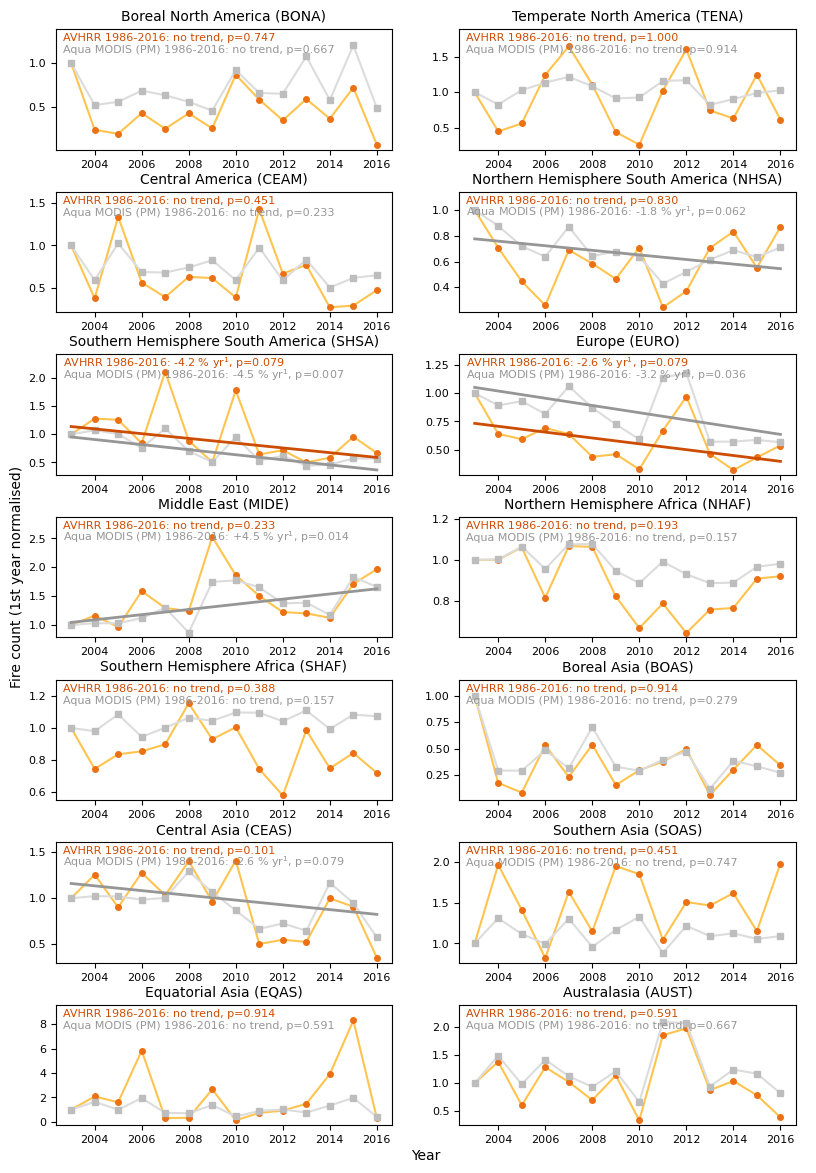

In [ ]:
fig, axes, stats_tbl = ts_plotter(df=aquapm_year, 
                                xstr='year',
                                y1str='n_count_avhrr',
                                y2str='n_count_modis',
                                series1_str = 'AVHRR',
                                series2_str = 'Aqua MODIS (PM)',
                                region_dict=region_dict, 
                                ylab="Fire count (1st year normalised)",
                                xlab="Year", 
                                av_color_list=av_color_list, fw_color_list=fw_color_list, 
                                nrow=7, ncol=2, 
                                dim = (210*mm,297*mm))
fig.tight_layout()


#figs
fig.savefig(str(dir_out_figures / 's11_timeseries_AVHRR_vs_MODIS_PM_1st_year_normalised.png'), dpi=1000)
#fig.savefig(str(dir_out_figures / 's4_timeseries_gfed_vpd_flip.pdf'))

#statstable
#stats_tbl.to_csv(str(dir_out_figures / 's4_timeseries_gfed_vpd_flip.csv'),index=False)
#print(stats_tbl)

0 BONA [None, None]
1 TENA [None, None]
2 CEAM [None, None]
3 NHSA [None, None]
4 SHSA [None, None]
5 EURO [None, None]
6 MIDE [None, None]
7 NHAF [None, None]
8 SHAF [None, None]
9 BOAS [None, None]
10 CEAS [None, None]
11 SOAS [None, None]
12 EQAS [None, None]
13 AUST [None, None]


C:\Users\mdejong\AppData\Local\Temp\ipykernel_96044\2005389917.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


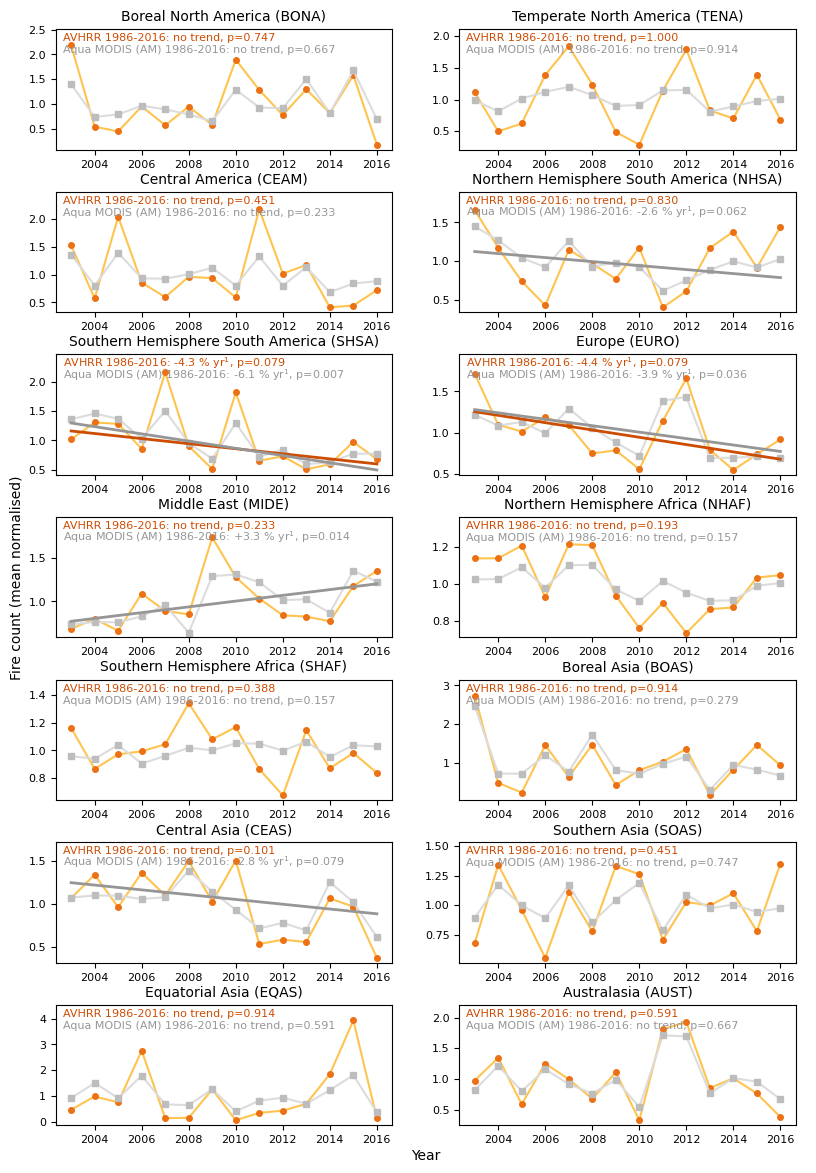

In [ ]:
fig, axes, stats_tbl = ts_plotter(df=aquapm_year, 
                                xstr='year',
                                y1str='n_count_avhrr_mean',
                                y2str='n_count_modis_mean',
                                series1_str = 'AVHRR',
                                series2_str = 'Aqua MODIS (AM)',
                                region_dict=region_dict, 
                                ylab="Fire count (mean normalised)",
                                xlab="Year", 
                                av_color_list=av_color_list, fw_color_list=fw_color_list, 
                                nrow=7, ncol=2, 
                                dim = (210*mm,297*mm))
fig.tight_layout()


#figs
fig.savefig(str(dir_out_figures / 's11_timeseries_AVHRR_vs_MODIS_PM_mean_normalised.png'), dpi=1000)
#fig.savefig(str(dir_out_figures / 's4_timeseries_gfed_vpd_flip.pdf'))

#statstable
#stats_tbl.to_csv(str(dir_out_figures / 's4_timeseries_gfed_vpd_flip.csv'),index=False)
#print(stats_tbl)

# GFED5 intercomparison

In [ ]:
dir_gfed_ba = dir_base / "aux_data/gfed5"

In [140]:
years=np.arange(2003,2016 + 1).tolist()
df_final_ba_totals = pd.DataFrame()

for i,year in enumerate(years):
    #load data
    fh = Dataset(dir_gfed_ba / f"GFED5_Beta_monthly_{year}.nc")
    regions = fh.variables['basisregions'][:]
    ba = fh.variables['burned_area'][:]

    #setup vars - basis regions obtained from file
    region_ids = np.unique(regions)

    # annual total
    ba_sum = np.nansum(ba, axis=0)

    # regional totals
    region_totals = []
    for i, rid in enumerate(region_ids):
        mask = (regions == rid)
        total = np.nansum(ba_sum[mask])
        region_totals.append({'region': rid, 'total_ba': total})
    
    #convert to a df and store
    df_region_totals = pd.DataFrame(region_totals)
    df_region_totals['year'] = year
    df_final_ba_totals = pd.concat([df_final_ba_totals, df_region_totals]).reset_index(drop=True)

print(df_final_ba_totals)

     region    total_ba  year
0         0    0.022959  2003
1         1   82.683624  2003
2         2  112.222816  2003
3         3  202.544556  2003
4         4  153.597809  2003
..      ...         ...   ...
205      10  554.378845  2016
206      11  520.208740  2016
207      12  893.729980  2016
208      13   19.782240  2016
209      14  489.824158  2016

[210 rows x 3 columns]


In [141]:
# normalise data to first year (2003)

ba2003 = df_final_ba_totals.loc[df_final_ba_totals.year == 2003].rename(columns={'total_ba':'total_ba2003'})
#norm the ensemble stats
df_final_ba_totals = df_final_ba_totals.merge(ba2003[['region','total_ba2003']],
                      how='left',
                      on=['region'])
df_final_ba_totals['n_ba'] = df_final_ba_totals['total_ba'] / df_final_ba_totals['total_ba2003'] 

# normalise data to mean

# AVHRR
ba_mean = df_final_ba_totals.groupby('region')['total_ba'].mean().reset_index().rename(columns={'total_ba':'ba_mean'})

#norm the ensemble stats
df_final_ba_totals = df_final_ba_totals.merge(ba_mean[['region','ba_mean']],
                      how='left',
                      on=['region'])
df_final_ba_totals['n_ba_mean'] = df_final_ba_totals['total_ba'] / df_final_ba_totals['ba_mean'] 



# drop unused
df_final_ba_totals = df_final_ba_totals.drop(['ba_mean','total_ba2003'], axis=1)
df_final_ba_totals.head()

,region,total_ba,year,n_ba,n_ba_mean
0,0,0.022959,2003,1.0,0.608222
1,1,82.683624,2003,1.0,0.792366
2,2,112.222816,2003,1.0,1.000496
3,3,202.544556,2003,1.0,1.168276
4,4,153.597809,2003,1.0,1.288911


In [142]:
# combine ba with the AM dataset
am = modis2.merge(df_final_ba_totals, how='left', on=['region','year'])
am.head(), am.shape, modis2.shape

(   region region_name  year  val_count  sat_yr sat  count  count_1st  val_count_1st               gfed_full_name  n_count_avhrr  n_count_modis  n_count_avhrr_mean  n_count_modis_mean    total_ba      n_ba  n_ba_mean
 0       1        BONA  2003       3438  NL2003  NL   1305        NaN            NaN  Boreal North America (BONA)       1.000000       1.000000            2.182535            2.243498   82.683624  1.000000   0.792366
 1       1        BONA  2004        961  NL2004  NL    322     -983.0        -2477.0  Boreal North America (BONA)       0.246743       0.279523            0.538526            0.627109  186.590576  2.256681   1.788117
 2       1        BONA  2005        571  NL2005  NL    263      -59.0         -390.0  Boreal North America (BONA)       0.201533       0.166085            0.439852            0.372611  123.864120  1.498049   1.187003
 3       1        BONA  2006       1129  NN2006  NN    567      304.0          558.0  Boreal North America (BONA)       0.434483    

0 BONA [None, None]
1 TENA [None, None]
2 CEAM [None, None]
3 NHSA [None, None]
4 SHSA [None, None]
5 EURO [None, None]
6 MIDE [None, None]
7 NHAF [None, None]
8 SHAF [None, None]
9 BOAS [None, None]
10 CEAS [None, None]
11 SOAS [None, None]
12 EQAS [None, None]
13 AUST [None, None]


C:\Users\mdejong\AppData\Local\Temp\ipykernel_96044\3294179364.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


0 BONA [None, None]
1 TENA [None, None]
2 CEAM [None, None]
3 NHSA [None, None]
4 SHSA [None, None]
5 EURO [None, None]
6 MIDE [None, None]
7 NHAF [None, None]
8 SHAF [None, None]
9 BOAS [None, None]
10 CEAS [None, None]
11 SOAS [None, None]
12 EQAS [None, None]
13 AUST [None, None]


C:\Users\mdejong\AppData\Local\Temp\ipykernel_96044\3294179364.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


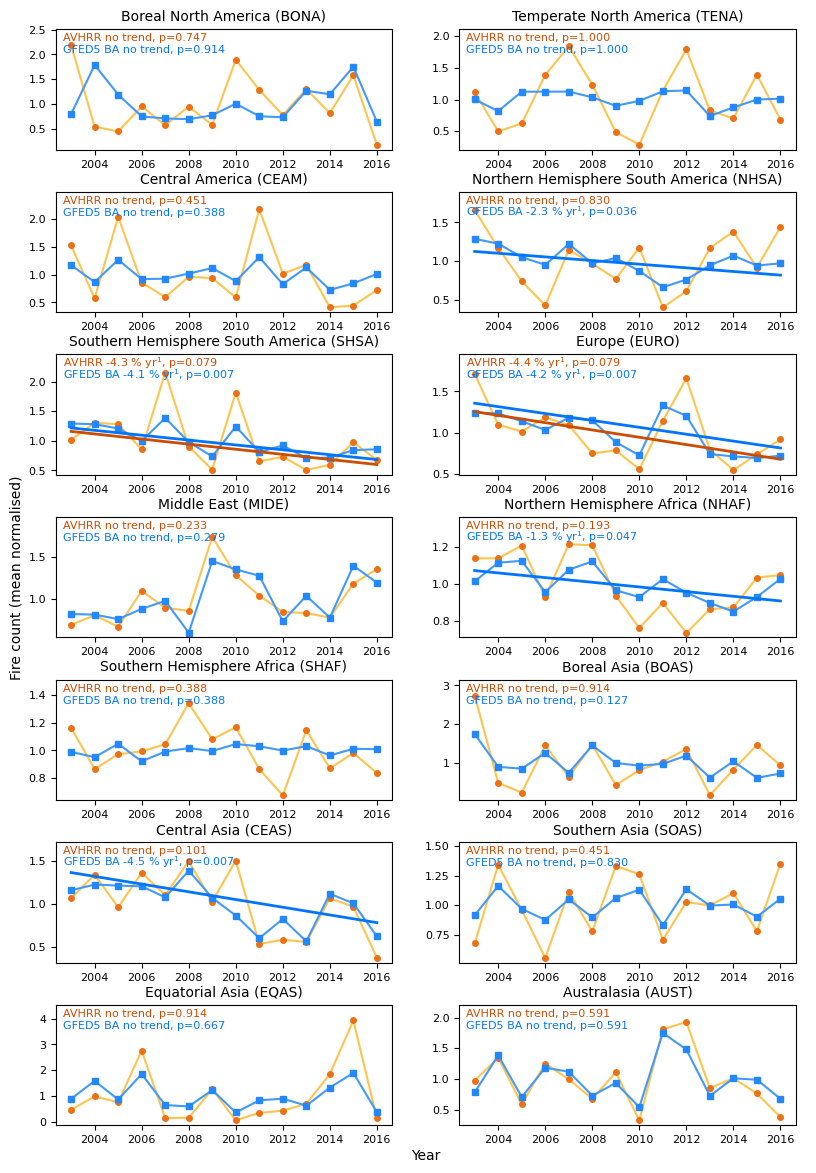

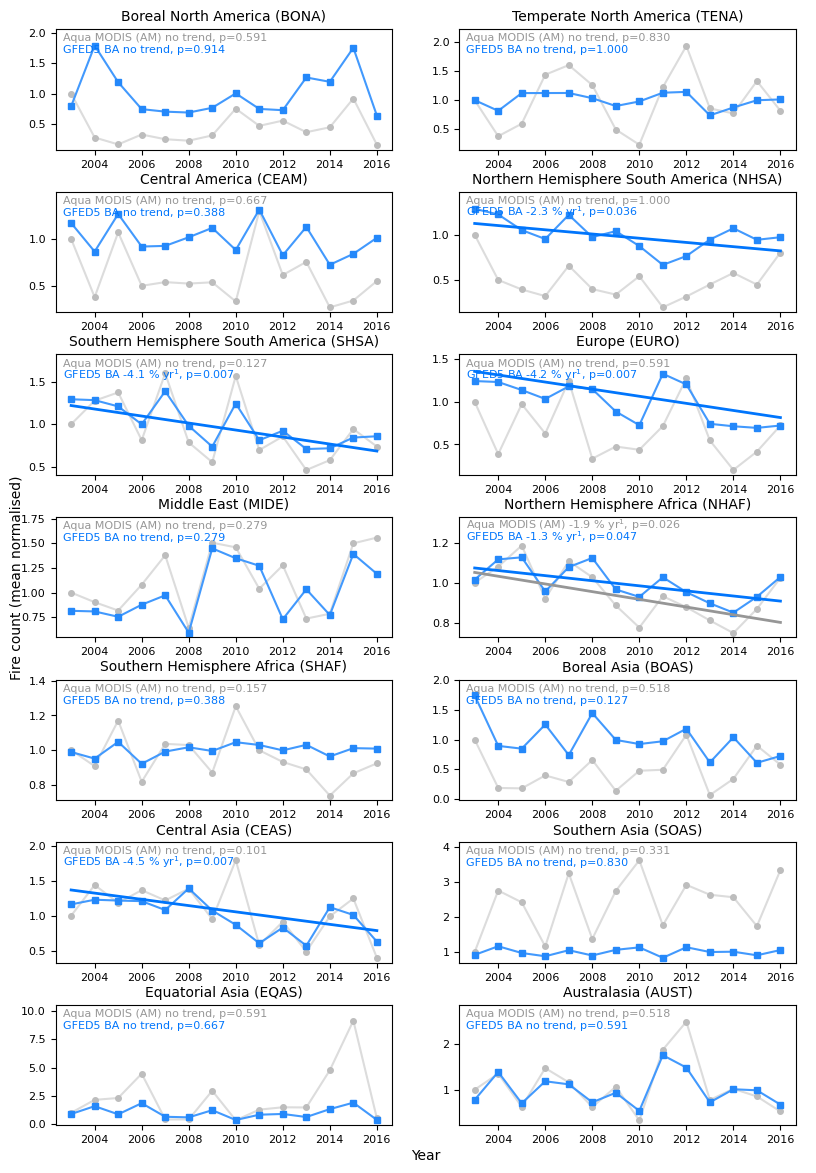

In [152]:
fig, axes, stats_tbl = ts_plotter(df=am, 
                                xstr='year',
                                y1str='n_count_avhrr_mean',
                                y2str='n_ba_mean',
                                series1_str = 'AVHRR',
                                series2_str = 'GFED5 BA',
                                region_dict=region_dict, 
                                ylab="Fire count (mean normalised)",
                                xlab="Year", 
                                av_color_list=av_color_list, fw_color_list=ba_color_list,
                                nrow=7, ncol=2, 
                                dim = (210*mm,297*mm))
fig.tight_layout()

#figs
fig.savefig(str(dir_out_figures / 's13_timeseries_AVHRR_vs_GFED5_mean_normalised.png'), dpi=1000)
#fig.savefig(str(dir_out_figures / 's4_timeseries_gfed_vpd_flip.pdf'))

#statstable
#stats_tbl.to_csv(str(dir_out_figures / 's4_timeseries_gfed_vpd_flip.csv'),index=False)
#print(stats_tbl)


fig, axes, stats_tbl = ts_plotter(df=am, 
                                xstr='year',
                                y1str='n_count_modis',
                                y2str='n_ba_mean',
                                series1_str = 'Aqua MODIS (AM)',
                                series2_str = 'GFED5 BA',
                                region_dict=region_dict, 
                                ylab="Fire count (mean normalised)",
                                xlab="Year", 
                                av_color_list=fw_color_list, fw_color_list=ba_color_list, 
                                nrow=7, ncol=2, 
                                dim = (210*mm,297*mm))
fig.tight_layout()

#figs
fig.savefig(str(dir_out_figures / 's13_timeseries_Aqua_MODIS_AM_vs_GFED5_mean_normalised.png'), dpi=1000)
#fig.savefig(str(dir_out_figures / 's4_timeseries_gfed_vpd_flip.pdf'))

#statstable
#stats_tbl.to_csv(str(dir_out_figures / 's4_timeseries_gfed_vpd_flip.csv'),index=False)
#print(stats_tbl)

plot all 3: AVHRR, MODIS and GFED BA

In [168]:
def ts_plotter_3series(df, xstr, y1str, y2str, y3str, series1_str, series2_str, series3_str, region_dict, ylab, xlab, av_color_list, fw_color_list, ba_color_list, 
                   nrow, ncol, dim = None, ax2rm = None, xlabpad=0, sharex=False):
    """ 
    func for plotting AVHRR vs. MODIS timeseries
    
    returns:
    fig: figure object 
    axes: axes objects
    stats: df, summary stats 
    """
    
    eq_list = ['$\leq$', ' > ']
    
    if dim:
        pass
    else:
        dim=(12,8)      
    
    fig, axes = plt.subplots(figsize=dim, nrows=nrow, ncols=ncol,
                           squeeze=False, sharex=sharex,
                           gridspec_kw=dict(hspace=0.35, wspace=0.2))
    axes=axes.flatten()
    
    if ax2rm:   # delete excess axes
        for i in np.arange(ax2rm, 0):
            fig.delaxes(axes[i])
            
    statstable = pd.DataFrame({'region': [],'metric':[],
                           'year_start':[],'year_end' : [], 
                           'tau':[],'p':[],'intercept': [],
                           'slope':[],'lower':[],'upper':[],
                          })
    for i, (key, values) in enumerate(region_dict.items()):
        print(i, key, values)
        sub = df.loc[df.region_name==key].copy()    
        #d_av = d_av.dropna()   
        
        x = sub[xstr].values    
        y1 = sub[y1str].values
        y2 = sub[y2str].values
        y3 = sub[y3str].values

        ax1 = axes[i]

        ### points & markers
        #AVHRR (oranges)
        ax1.plot(x, y1, marker='', ms=4, linestyle='-', color=av_color_list[0], label=key, alpha=1, zorder=1) 
        ax1.plot(x, y1, marker='o', ms=4, linestyle='none', color=av_color_list[1], label=key, alpha=1, zorder=2) #3690c0
        #Other (greys)
        ax1.plot(x, y2, marker='', ms=4, linestyle='-', color=fw_color_list[0], label=key, alpha=1, zorder=2)
        ax1.plot(x, y2, marker='s', ms=4, linestyle='none', color=fw_color_list[1], label=key, alpha=1, zorder=2) #fe9929        
        # 3rd series
        ax1.plot(x, y3, marker='', ms=4, linestyle='-', color=ba_color_list[0], label=key, alpha=1, zorder=2)
        ax1.plot(x, y3, marker='x', ms=4, linestyle='none', color=ba_color_list[1], label=key, alpha=1, zorder=2) #fe9929         
        
        # first calc & store the 1986-2016 AVHRR stats      
        tau2, p2, slope2, intercept2, lower2, upper2 = utils.kendall_theilsen(x, y1)
        #tau_n2, p_n2, slope_n2, intercept_n2, lower_n2, upper_n2 = utils.kendall_theilsen(x, y1)   
        statstable.loc[len(statstable)] = [key, 'avhrr', x[0], x[-1], 
                       round(tau2,6), round(p2,6), round(intercept2,6), 
                       round(slope2,6), round(lower2,6), round(upper2,6)]
        
        # first calc & store the 1986-2016 other stats 
        tau1, p1, slope1, intercept1, lower1, upper1 = utils.kendall_theilsen(x, y2)        
        #tau_n1, p_n1, slope_n1, intercept_n1, lower_n1, upper_n1 = utils.kendall_theilsen(x, y2)
        statstable.loc[len(statstable)] = [key, 'other dataset', x[0], x[-1], 
                         round(tau1,6), round(p1,6), round(intercept1,6), 
                         round(slope1,6), round(lower1,6), round(upper1,6)]    
    
        # first calc & store the 1986-2016 other stats 
        tau3, p3, slope3, intercept3, lower3, upper3 = utils.kendall_theilsen(x, y3)        
        #tau_n1, p_n1, slope_n1, intercept_n1, lower_n1, upper_n1 = utils.kendall_theilsen(x, y2)
        statstable.loc[len(statstable)] = [key, 'other dataset', x[0], x[-1], 
                         round(tau3,6), round(p3,6), round(intercept3,6), 
                         round(slope3,6), round(lower3,6), round(upper3,6)] 
        
        #PLOT TRENDS ###
        # AVHRR ============

        if p2 < 0.1:
            ax1.plot(x, x * slope2 + intercept2, av_color_list[2], linewidth=2, linestyle='-', zorder=1000)
            if p2 < 0.001:
                label=r'{} {:+.1f} % yr$^1$, p<0.001'.format(series1_str, np.round(slope2 * 100,1)) 
            else:            
                label=r'{} {:+.1f} % yr$^1$, p={:.3f}'.format(series1_str, np.round(slope2 * 100,1), np.round(p2,3)) 
            plt.text(0.02, 0.9, label, color=av_color_list[2], fontsize=8, transform = ax1.transAxes)
        else:
            label=r'{} no trend, p={:.3f}'.format(series1_str, np.round(p2,3)) 
            plt.text(0.02, 0.9, label, color=av_color_list[2], fontsize=8, transform = ax1.transAxes)        
        #print('avhrr p-value:', d_av.gfed_full_name.values[0], p_n2)
        
        #  SECOND ===========

        txt_offset = 1 * 0.1
        if values[0]: # if AVHRRR has a change
            yloc=0.7
        else:
            yloc=0.9 - txt_offset        
        if p1 < 0.1:
            ax1.plot(x, x * slope1 + intercept1, fw_color_list[2], linewidth=2, linestyle='-', zorder=1000)
            if p1 < 0.001:
                label=r'{} {:+.1f} % yr$^1$, p<0.001'.format(series2_str, np.round(slope1 * 100,1)) 
            else:
                label=r'{} {:+.1f} % yr$^1$, p={:.3f}'.format(series2_str, np.round( slope1 * 100,1), np.round(p1,3)) 
            plt.text(0.02, yloc, label, color=fw_color_list[2], fontsize=8, transform = ax1.transAxes)
        else:
            #label=r'{} p={:.3f}'.format(series2_str, np.round(p1,3))
            label=r'{} no trend, p={:.3f}'.format(series2_str, np.round(p1,3))
            plt.text(0.02, yloc, label, color=fw_color_list[2], fontsize=8, transform = ax1.transAxes)        
        
        #  THIRD ===========

        txt_offset = 1 * 0.2
        if values[0]: # if AVHRRR has a change
            yloc=0.6
        else:
            yloc=0.9 - txt_offset        
        if p1 < 0.1:
            ax1.plot(x, x * slope3 + intercept3, ba_color_list[2], linewidth=2, linestyle='-', zorder=1000)
            if p1 < 0.001:
                label=r'{} {:+.1f} % yr$^1$, p<0.001'.format(series3_str, np.round(slope3 * 100,1)) 
            else:
                label=r'{} {:+.1f} % yr$^1$, p={:.3f}'.format(series3_str, np.round( slope3 * 100,1), np.round(p3,3)) 
            plt.text(0.02, yloc, label, color=ba_color_list[2], fontsize=8, transform = ax1.transAxes)
        else:
            #label=r'{} p={:.3f}'.format(series2_str, np.round(p3,3))
            label=r'{} no trend, p={:.3f}'.format(series3_str, np.round(p3,3))
            plt.text(0.02, yloc, label, color=ba_color_list[2], fontsize=8, transform = ax1.transAxes)      
        
        # tidy up subplot
        ax1.set_title(sub.gfed_full_name.values[0], fontsize=10)   
        # expand upper y limits for text
        ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1] * 1.1)

        # adjust tick label font sizes
        ax1.tick_params(axis='both', which='major', labelsize=8)
        ax1.tick_params(axis='both', which='minor', labelsize=8)
        
    # broad axis labels on dummy ax
    fig.add_subplot(111, frameon=False)
    ax1 = plt.gca()
    #ax2 = ax1.twinx()
    ax1.set_xlabel(xlab, color='k', fontsize=10, labelpad=xlabpad)
    ax1.set_ylabel(ylab, color='k', fontsize=10, labelpad=0)    
    
    plt.box(False)
    ax1.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    return fig, axes, statstable

In [164]:
print(ba_color_list),print(fw_color_list)

['#4299fd', '#2488fa', '#0075fc']
['#dcdcdc', '#bdbdbd', '#969696']


(None, None)

0 BONA [None, None]
1 TENA [None, None]
2 CEAM [None, None]
3 NHSA [None, None]
4 SHSA [None, None]
5 EURO [None, None]
6 MIDE [None, None]
7 NHAF [None, None]
8 SHAF [None, None]
9 BOAS [None, None]
10 CEAS [None, None]
11 SOAS [None, None]
12 EQAS [None, None]
13 AUST [None, None]


C:\Users\mdejong\AppData\Local\Temp\ipykernel_96044\1707622672.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


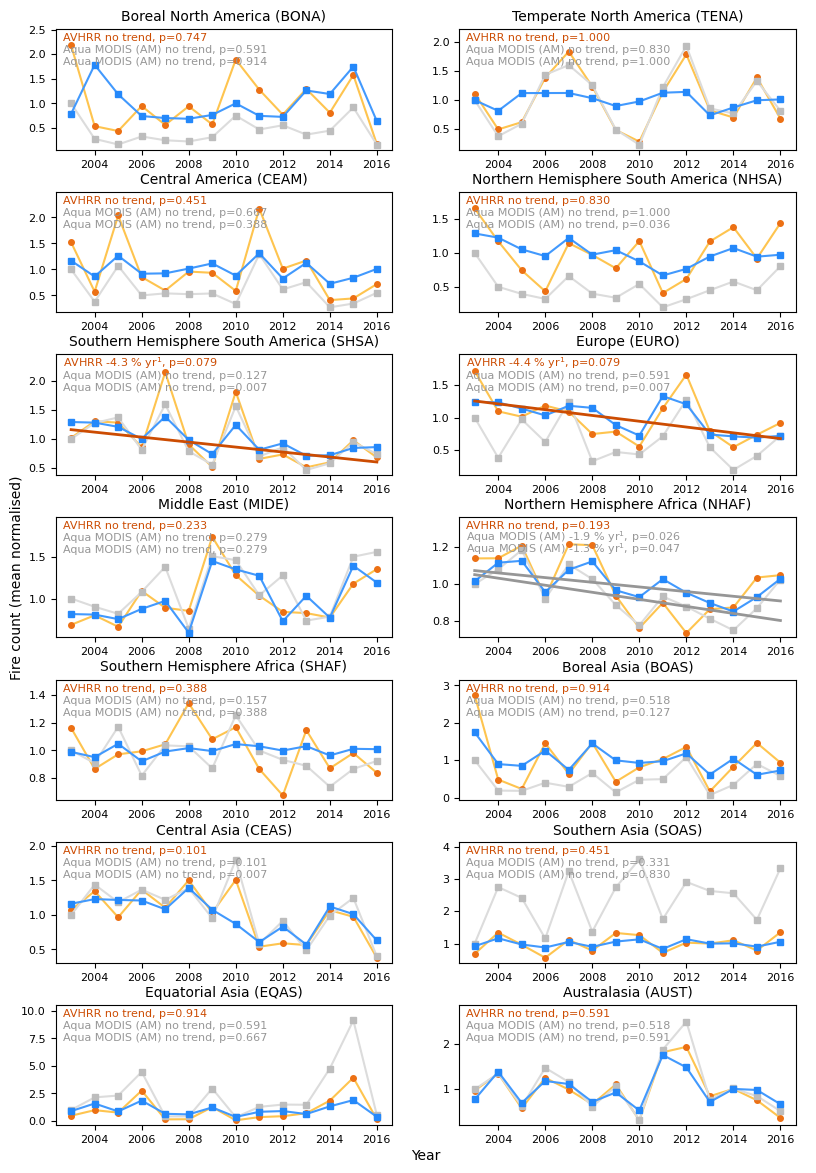

In [169]:
fig, axes, stats_tbl = ts_plotter(df=am, 
                                xstr='year',
                                y1str='n_count_avhrr_mean',
                                y2str='n_count_modis',
                                y3str='n_ba_mean',
                                series1_str ='AVHRR',
                                series2_str = 'Aqua MODIS (AM)',
                                series3_str = 'GFED5 BA',
                                region_dict=region_dict, 
                                ylab="Fire count (mean normalised)",
                                xlab="Year", 
                                av_color_list=av_color_list, 
                                fw_color_list=fw_color_list, 
                                ba_color_list=ba_color_list,
                                nrow=7, ncol=2, 
                                dim = (210*mm,297*mm))
fig.tight_layout()

#figs
#fig.savefig(str(dir_out_figures / 's13_timeseries_Aqua_MODIS_AM_vs_GFED5_mean_normalised.png'), dpi=1000)